In [1]:
from keras.optimizers import Adadelta
from keras.models import load_model
import os
import numpy as np
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from keras import backend as K
import h5py

import sys
sys.path.insert(1, 'utils/')
from deep_models import *
from utils_challenge import *
from utils_projections import *
from np_ioueval import iouEval

Using TensorFlow backend.


## Paths to models and data

In [2]:
model_path = 'external_data/trained_model/model_unet6.hdf5'

data_path = 'external_data/spherical_projections/validation/'
features_path = data_path + '/features_without_ground/'
gt_path = data_path + '/gt_without_ground/'

## Load trained model

In [3]:
model = load_model(model_path, compile= False)
model.compile(loss=jaccard2_loss, optimizer=Adadelta())    
model.summary()

kwargs {}
dict {}
p_value 2.0
shape ()
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 5, 64, 1024)  0                                            
__________________________________________________________________________________________________
gaussian_noise_1 (GaussianNoise (None, 5, 64, 1024)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 32, 512)  8064        gaussian_noise_1[0][0]           
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 64, 32, 512)  0           conv2d_1[0][0]                   
______________________________________________________________________

## Data to predict labels

Files in external_data/spherical_projections are image

In [4]:
id_point_cloud = '78.h5' # point clouds in external_data/spherical_projections/validation

In [5]:
feature_names = ['z','depth', 'nx', 'ny', 'nz']
input_channels = [2,3,4,5,6]

In [6]:
X_to_pred = load_features_spherical(features_path, id_point_cloud, channels=input_channels)

z_channel = X_to_pred[0,feature_names.index('z'),:,:]
depth_channel = X_to_pred[0,feature_names.index('depth'),:,:]
nx_channel = X_to_pred[0,feature_names.index('nx'),:,:]
ny_channel = X_to_pred[0,feature_names.index('ny'),:,:]
nz_channel = X_to_pred[0,feature_names.index('nz'),:,:]

Visualize each channel of input image

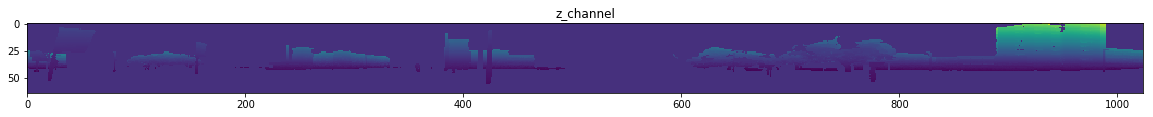

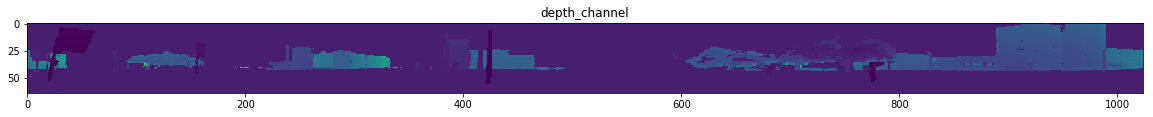

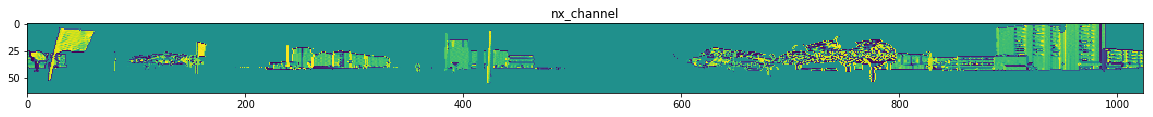

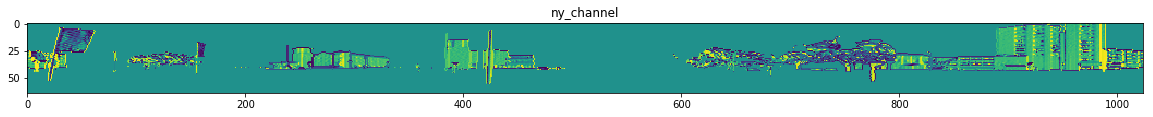

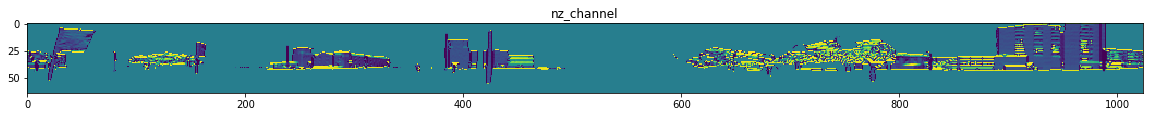

In [7]:
plt.figure(figsize=(20,10))
plt.title("z_channel")
plt.imshow(z_channel)
plt.show()

plt.figure(figsize=(20,10))
plt.title("depth_channel")
plt.imshow(depth_channel)
plt.show()

plt.figure(figsize=(20,10))
plt.title("nx_channel")
plt.imshow(nx_channel)
plt.show()

plt.figure(figsize=(20,10))
plt.title("ny_channel")
plt.imshow(ny_channel)
plt.show()

plt.figure(figsize=(20,10))
plt.title("nz_channel")
plt.imshow(nz_channel)
plt.show()

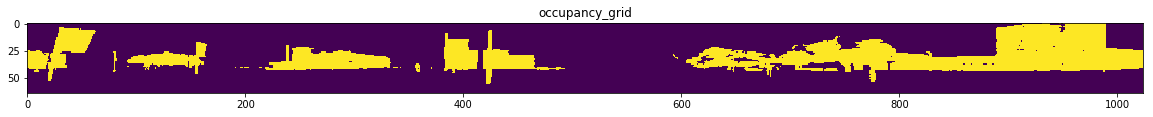

In [8]:
empty_pixels = np.where( (nx_channel == 0) & (ny_channel == 0) & (nz_channel == 0))
occupancy_grid = np.ones_like(nx_channel)
occupancy_grid[empty_pixels] = 0

plt.figure(figsize=(20,10))
plt.title("occupancy_grid")
plt.imshow(occupancy_grid)
plt.show()


## Predict labels 

In [9]:
y_pred = model.predict(X_to_pred)
y_pred = np.argmax(y_pred,axis=1)+1
y_pred = y_pred[0,:,:]


In [10]:
color_map = {
    -1: [0, 0, 0],    # empty -> black
    0: [0, 0, 0],     # undefined -> black
    1: [255, 0, 0],   # building -> red
    2: [255, 255, 0], # car -> yellow
    3: [0, 0, 255],   # ground -> blue
    4: [0, 255, 255], # pole -> cyan
    5: [0, 255, 0]    # vegetation -> green
}

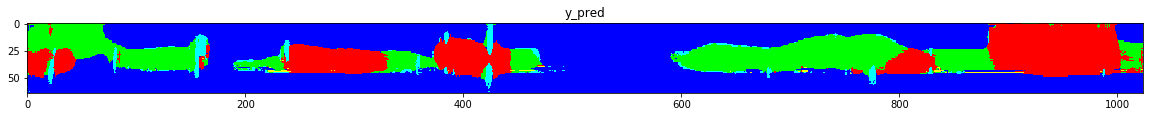

In [11]:
plt.figure(figsize=(20,10))
plt.imshow(map_gt_to_colored(y_pred, color_map))
plt.title("y_pred")
plt.show()

Assign to zero empty pixels in spherical view

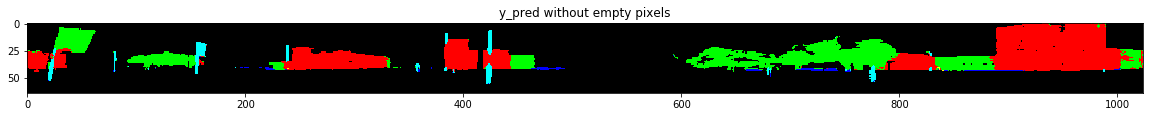

In [12]:
y_pred[empty_pixels] = 0
plt.figure(figsize=(20,10))
plt.imshow(map_gt_to_colored(y_pred, color_map))
plt.title("y_pred without empty pixels")
plt.show()

Load ground truth to compare against predicted labels

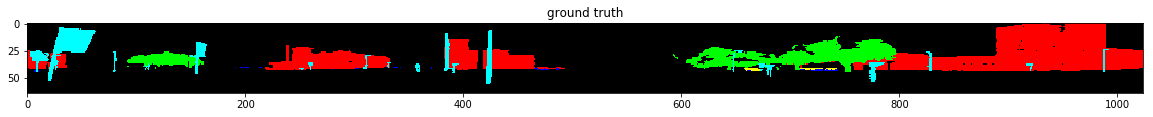

In [13]:
full_name = os.path.join(gt_path, id_point_cloud)
with h5py.File(full_name, 'r') as hf:
    Y_gt = hf['array'][:]  
plt.figure(figsize=(20,10))
plt.imshow(map_gt_to_colored(Y_gt, color_map))
plt.title("ground truth")
plt.show()